<a href="https://colab.research.google.com/github/sanskriti-03-04/Custom-Programming-Language/blob/main/MyLang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🔹 Lexer – Tokenizing Source Code

## 📌 Purpose
The lexer breaks down raw source code into individual tokens. These tokens represent the atomic building blocks of our programming language — such as numbers, identifiers, keywords, operators, and symbols.

## 🔍 How It Works
- Uses Python's `re` module to apply regular expression patterns.
- Identifies and labels tokens like `NUMBER`, `ID`, `PLUS`, `EQUAL`, `PRINT`, etc.
- Automatically classifies identifiers like `print`, `if`, and `while` as keywords.
- Ignores whitespace and raises syntax errors for unknown characters.

## ✅ Features
- Supports arithmetic (`+`, `-`, `*`, `/`)
- Supports comparison (`==`, `!=`, `<`, `>`, `<=`, `>=`)
- Recognizes parentheses, assignment, and colons
- Converts keywords to token types (e.g., `print` → `PRINT`)
- Skips whitespace and newlines
- Easily extensible via `TOKEN_SPEC`

## 🧪 Example

```python
Source Code:
a = 5 + 3

Token Output:
[('ID', 'a'), ('ASSIGN', '='), ('NUMBER', 5), ('PLUS', '+'), ('NUMBER', 3)]


In [29]:
import re

KEYWORDS = {
    'def': 'DEF',
    'return': 'RETURN',
    'if': 'IF',
    'else': 'ELSE',
    'while': 'WHILE',
    'print': 'PRINT',
}


TOKEN_SPEC = [
    ('NUMBER',   r'\d+'),
    ('ID',       r'[A-Za-z_][A-Za-z0-9_]*'),
    ('EQ',       r'=='),
    ('NE',       r'!='),
    ('LE',       r'<='),
    ('GE',       r'>='),
    ('LT',       r'<'),
    ('GT',       r'>'),
    ('ASSIGN',   r'='),
    ('PLUS',     r'\+'),
    ('MINUS',    r'-'),
    ('MUL',      r'\*'),
    ('DIV',      r'/'),
    ('LPAREN',   r'\('),
    ('RPAREN',   r'\)'),
    ('COLON',    r':'),
    ('NEWLINE',  r'\n'),
    ('SKIP',     r'[ \t]+'),
    ('COMMA',    r','),
    ('MISMATCH', r'.'),
     ('DEF',      r'\bdef\b'),         # Optional if not handled by KEYWORDS
    ('RETURN',   r'\breturn\b'),      # Optional if not handled by KEYWORDS


]

TOK_REGEX = '|'.join(f'(?P<{name}>{regex})' for name, regex in TOKEN_SPEC)

def tokenize(code):
    lineno = 1
    line_start = 0
    for mo in re.finditer(TOK_REGEX, code):
        kind = mo.lastgroup
        value = mo.group()
        if kind == 'NUMBER':
            value = int(value)
        elif kind == 'ID' and value in KEYWORDS:
            kind = value.upper()
        elif kind == 'SKIP':
            continue
        elif kind == 'NEWLINE':
            lineno += 1
            line_start = mo.end()
            continue
        elif kind == 'MISMATCH':
            raise SyntaxError(f'Unexpected character {value!r} on line {lineno}')
        yield (kind, value)

# 🔹 AST Design – Abstract Syntax Tree for MyLang

## 📌 Purpose
The **Abstract Syntax Tree (AST)** is a hierarchical representation of the program structure. It eliminates irrelevant syntax (like parentheses or semicolons) and focuses on the actual meaning of the program — making it easier to **interpret, optimize, or compile**.

## 🔧 Why Use an AST?
- Clearly separates structure from raw syntax
- Enables evaluation, code generation, and transformation
- Makes it easy to apply recursion and scope

---

## 🧱 Core AST Node Types

### 🧮 Literals and Variables
```python
class Number:
    def __init__(self, value): self.value = value

class Var:
    def __init__(self, name): self.name = name


In [3]:
class ASTNode: pass

class Number(ASTNode):
    def __init__(self, value): self.value = value

class Var(ASTNode):
    def __init__(self, name): self.name = name

class BinOp(ASTNode):
    def __init__(self, left, op, right):
        self.left = left
        self.op = op
        self.right = right

class Assign(ASTNode):
    def __init__(self, name, expr):
        self.name = name
        self.expr = expr

class Print(ASTNode):
    def __init__(self, expr): self.expr = expr

class Block(ASTNode):
    def __init__(self, statements): self.statements = statements

class If(ASTNode):
    def __init__(self, condition, then_branch, else_branch=None):
        self.condition = condition
        self.then_branch = then_branch
        self.else_branch = else_branch

class While(ASTNode):
    def __init__(self, condition, body):
        self.condition = condition
        self.body = body
class FunctionDef(ASTNode):
    def __init__(self, name, params, body):
        self.name = name
        self.params = params  # list of parameter names
        self.body = body      # typically a Block

class Call(ASTNode):
    def __init__(self, name, args):
        self.name = name
        self.args = args      # list of expressions

class Return(ASTNode):
    def __init__(self, value):
        self.value = value


# 🔹 Parser – Building the Abstract Syntax Tree (AST)

## 📌 Purpose
The parser takes the token stream produced by the lexer and builds an **Abstract Syntax Tree (AST)** — a structured representation of the source code’s meaning.

## 🔍 How It Works
- Implements a **recursive descent parser**
- Handles arithmetic expressions with correct **precedence**
- Supports variable assignment and `print` statements
- Constructs AST nodes like `Assign`, `BinOp`, `Var`, `Number`, and `Print`

## 🧱 AST Nodes Implemented
- `Number(value)`: Represents numeric literals
- `Var(name)`: Represents variables
- `Assign(name, expr)`: Variable assignment
- `BinOp(left, op, right)`: Binary operations (`+`, `-`, `*`, `/`)
- `Print(expr)`: Output expression result

## 🔁 Precedence Rules
- `term()` → `*` and `/`
- `expr()` → `+` and `-`
- `factor()` → numbers, identifiers, parentheses

## 🧪 Example

```python
Code:
a = 3 + 2 * 5
print(a)

AST:
Assign('a', BinOp(Number(3), '+', BinOp(Number(2), '*', Number(5))))
Print(Var('a'))


In [5]:
class Parser:
    def __init__(self, tokens):
        self.tokens = list(tokens)
        self.pos = 0

    def current(self):
        return self.tokens[self.pos] if self.pos < len(self.tokens) else (None, None)

    def eat(self, kind):
        tok = self.current()
        if tok[0] == kind:
            self.pos += 1
            return tok
        raise SyntaxError(f'Expected {kind}, got {tok[0]}')

    def parse(self):
        stmts = []
        while self.pos < len(self.tokens):
            stmt = self.statement()
            if stmt:
                stmts.append(stmt)
            else:
                # Handle potential infinite loop if statement() returns None without consuming tokens
                if self.pos < len(self.tokens) and self.current()[0] not in ('NEWLINE', 'SKIP'):
                     raise SyntaxError(f"Unexpected token at the beginning of a statement: {self.current()}")
                # If statement() returned None because of SKIP or NEWLINE, just continue the loop
                elif self.pos < len(self.tokens) and self.current()[0] in ('NEWLINE', 'SKIP'):
                     continue
                else:
                    break # Exit loop if no statement is parsed and no more tokens

        return Block(stmts)


    def statement(self):
        tok = self.current()
        if tok[0] == 'ID':
            # Handle function calls
            if self.pos + 1 < len(self.tokens) and self.tokens[self.pos + 1][0] == 'LPAREN':
                func_name = self.eat('ID')[1]
                self.eat('LPAREN')
                args = []
                if self.current()[0] != 'RPAREN':
                    args.append(self.expr())
                    while self.current()[0] == 'COMMA':
                        self.eat('COMMA')
                        args.append(self.expr())
                self.eat('RPAREN')
                # Optional newline after function call
                if self.current()[0] == 'NEWLINE':
                    self.eat('NEWLINE')
                return Call(func_name, args)
            else:
                # Handle variable assignment
                var = self.eat('ID')[1]
                self.eat('ASSIGN')
                expr = self.expr()
                # Optional newline after assignment
                if self.current()[0] == 'NEWLINE':
                    self.eat('NEWLINE')
                return Assign(var, expr)
        elif tok[0] == 'PRINT':
            self.eat('PRINT')
            expr = self.expr()
            # Optional newline after print
            if self.current()[0] == 'NEWLINE':
                self.eat('NEWLINE')
            return Print(expr)
        elif tok[0] == 'IF':
            self.eat('IF')
            cond = self.expr()
            self.eat('COLON')  # Expect a colon after the condition
            # Optional newline after the colon for single-line if statements
            if self.current()[0] == 'NEWLINE':
                self.eat('NEWLINE')

            then_branch_statements = []
            # Parse statements in the then branch until ELSE or end of tokens
            while self.pos < len(self.tokens) and self.current()[0] != 'ELSE':
                 stmt = self.statement()
                 if stmt:
                     then_branch_statements.append(stmt)
                 else:
                     break # Exit if statement() returns None
            then_branch = Block(then_branch_statements)


            else_branch = None
            if self.current()[0] == 'ELSE':
                self.eat('ELSE')
                self.eat('COLON')  # Expect a colon after ELSE
                # Optional newline after the colon for single-line else statements
                if self.current()[0] == 'NEWLINE':
                    self.eat('NEWLINE')

                else_branch_statements = []
                # Parse statements in the else branch until end of tokens
                while self.pos < len(self.tokens):
                    stmt = self.statement()
                    if stmt:
                        else_branch_statements.append(stmt)
                    else:
                        break # Exit if statement() returns None
                else_branch = Block(else_branch_statements)

            return If(cond, then_branch, else_branch)
        elif tok[0] == 'WHILE':
            self.eat('WHILE')
            condition = self.expr()
            self.eat('COLON')  # Expect a colon after the condition
            # Optional newline after the colon for single-line while statements
            if self.current()[0] == 'NEWLINE':
                self.eat('NEWLINE')

            body_statements = []
            # Parse statements in the while body until end of tokens or a non-indented line
            while self.pos < len(self.tokens): # Need a better way to handle indented blocks
                stmt = self.statement()
                if stmt:
                    body_statements.append(stmt)
                else:
                    break # Exit if statement() returns None
            body = Block(body_statements)
            return While(condition, body)

        elif tok[0] == 'DEF':
            self.eat('DEF')
            func_name = self.eat('ID')[1]
            self.eat('LPAREN')
            params = []
            if self.current()[0] != 'RPAREN':
                params.append(self.eat('ID')[1])
                while self.current()[0] == 'COMMA':
                    self.eat('COMMA')
                    params.append(self.eat('ID')[1])
            self.eat('RPAREN')
            if self.current()[0] == 'COLON':
                self.eat('COLON')
            body = Block([self.statement()]) # This needs to handle blocks of statements, not just one
            return FunctionDef(func_name, params, body)

        elif tok[0] == 'RETURN':
            self.eat('RETURN')
            value = self.expr()
            return Return(value)

        elif tok[0] == 'NEWLINE':
            self.eat('NEWLINE')
            return None # Skip newlines between statements
        elif tok[0] == 'SKIP':
            self.eat('SKIP')
            return None # Skip whitespace
        else:
            return None # No statement matched



    def expr(self):
        left = self.term()
        while self.current()[0] in ('PLUS', 'MINUS', 'EQ', 'NE', 'LE', 'GE', 'LT', 'GT'): # Added comparison operators
            op = self.eat(self.current()[0])[1]
            right = self.term()
            left = BinOp(left, op, right)
        return left

    def term(self):
        left = self.factor()
        while self.current()[0] in ('MUL', 'DIV'):
            op = self.eat(self.current()[0])[1]
            right = self.factor()
            left = BinOp(left, op, right)
        return left

    def factor(self):
        tok = self.current()
        if tok[0] == 'NUMBER':
            return Number(self.eat('NUMBER')[1])
        elif tok[0] == 'ID':
            # Handle function calls
            if self.pos + 1 < len(self.tokens) and self.tokens[self.pos + 1][0] == 'LPAREN':
                func_name = self.eat('ID')[1]
                self.eat('LPAREN')
                args = []
                if self.current()[0] != 'RPAREN':
                    args.append(self.expr())
                    while self.current()[0] == 'COMMA':
                        self.eat('COMMA')
                        args.append(self.expr())
                self.eat('RPAREN')
                return Call(func_name, args)
            else:
                return Var(self.eat('ID')[1])
        elif tok[0] == 'LPAREN':
            self.eat('LPAREN')
            expr = self.expr()
            self.eat('RPAREN')
            return expr
        else:
            raise SyntaxError(f'Unexpected token: {tok}')

In [ ]:
class BinOp:
    def __init__(self, left, op, right):
        self.left = left
        self.op = op
        self.right = right

class Assign:
    def __init__(self, name, expr):
        self.name = name
        self.expr = expr


In [ ]:
class Print:
    def __init__(self, expr): self.expr = expr


In [ ]:
class If:
    def __init__(self, condition, then_branch, else_branch):
        self.condition = condition
        self.then_branch = then_branch
        self.else_branch = else_branch

class While:
    def __init__(self, condition, body):
        self.condition = condition
        self.body = body

# 🔹 Interpreter – Executing the AST

## 📌 Purpose
The interpreter traverses the Abstract Syntax Tree (AST) and executes the program **directly in memory** — without compiling it to another form like bytecode.

This is called a **tree-walking interpreter**, where each node is evaluated recursively.

---

## ⚙️ How It Works
- Maintains a global environment (`env`) as a dictionary
- Evaluates expressions like `3 + 4 * 2` using AST `BinOp` nodes
- Supports variable declarations and usage
- Executes print statements by evaluating and printing the expression result

---

## 🧱 Execution Examples

### Sample Source Code:
```my
a = 3 + 2 * 5
print(a)


In [ ]:
class Interpreter:
    def __init__(self):
        self.env = {}

    def eval(self, node):
        if isinstance(node, Number):
            return node.value

        elif isinstance(node, Var):
            if node.name not in self.env:
                raise NameError(f"Undefined variable '{node.name}'")
            return self.env[node.name]

        elif isinstance(node, BinOp):
            left = self.eval(node.left)
            right = self.eval(node.right)
            if node.op == '+': return left + right
            elif node.op == '-': return left - right
            elif node.op == '*': return left * right
            elif node.op == '/': return left // right
            else:
                raise RuntimeError(f"Unknown operator {node.op}")

        elif isinstance(node, Assign):
            value = self.eval(node.expr)
            self.env[node.name] = value

        elif isinstance(node, Print):
            value = self.eval(node.expr)
            print(value)

        elif isinstance(node, Block):
            for stmt in node.statements:
                self.eval(stmt)

        else:
            raise RuntimeError(f"Unknown AST node {type(node).__name__}")


In [ ]:
code = """
a = 5
b = a + 3 * 2
print(b)
"""

tokens = tokenize(code)
parser = Parser(tokens)
ast = parser.parse()

interpreter = Interpreter()
for stmt in ast.statements:
    interpreter.eval(stmt)



11


# 🔹 Phase 2 – Bytecode Compiler and Virtual Machine

## 📌 Overview
We’ve now upgraded `MyLang` to use a **compiler + VM** architecture. This simulates how real programming languages are executed under the hood.

---

## 🛠 How It Works

### ✅ Compiler
- Traverses the AST
- Emits bytecode instructions using a **stack-based model**
- Example instruction: `PUSH 3`, `MUL`, `STORE a`

### ✅ Virtual Machine
- Executes instructions using:
  - A **stack** for temporary values
  - An **environment** for variables

---

## 🧪 Example Program

```my
a = 5
b = a + 3 * 2
print(b)


In [23]:
class Compiler:
    def __init__(self):
        self.instructions = []
        self.functions = {}  # name -> instruction start index

    def compile(self, node):
        if isinstance(node, Number):
            self.instructions.append(('PUSH', node.value))

        elif isinstance(node, Var):
            self.instructions.append(('LOAD', node.name))

        elif isinstance(node, BinOp):
            self.compile(node.left)
            self.compile(node.right)
            if node.op == '+': self.instructions.append(('ADD',))
            elif node.op == '-': self.instructions.append(('SUB',))
            elif node.op == '*': self.instructions.append(('MUL',))
            elif node.op == '/': self.instructions.append(('DIV',))
            # Handle comparison operators
            elif node.op == '==': self.instructions.append(('EQ',))
            elif node.op == '!=': self.instructions.append(('NE',))
            elif node.op == '<=': self.instructions.append(('LE',))
            elif node.op == '>=': self.instructions.append(('GE',))
            elif node.op == '<': self.instructions.append(('LT',))
            elif node.op == '>': self.instructions.append(('GT',))


        elif isinstance(node, Assign):
            self.compile(node.expr)
            self.instructions.append(('STORE', node.name))

        elif isinstance(node, Print):
            self.compile(node.expr)
            self.instructions.append(('PRINT',))

        elif isinstance(node, Block):
            for stmt in node.statements:
                self.compile(stmt)
        elif isinstance(node, If):
            self.compile(node.condition)
            jump_if_false_index = len(self.instructions)
            self.instructions.append(('JUMP_IF_FALSE', None))  # placeholder
            self.compile(node.then_branch)
            jump_index = len(self.instructions)
            self.instructions.append(('JUMP', None))  # unconditional jump after then_branch
            self.instructions[jump_if_false_index] = ('JUMP_IF_FALSE', len(self.instructions))
            if node.else_branch:
              self.compile(node.else_branch)
              self.instructions[jump_index] = ('JUMP', len(self.instructions))
            else:
              # This else block is for the case where there is no else_branch in the AST
              # The previous else branch was incorrectly raising an error here.
              # We don't need to do anything if there's no else branch, as the JUMP_IF_FALSE
              # will handle skipping the then_branch if the condition is false.
              pass
        elif isinstance(node, While):
            loop_start_index = len(self.instructions)
            self.compile(node.condition)
            jump_if_false_index = len(self.instructions)
            self.instructions.append(('JUMP_IF_FALSE', None))  # placeholder
            self.compile(node.body)
            self.instructions.append(('JUMP', loop_start_index))
            self.instructions[jump_if_false_index] = ('JUMP_IF_FALSE', len(self.instructions))
        elif isinstance(node, FunctionDef):
            self.functions[node.name] = len(self.instructions)
            self.instructions.append(('FUNC', node.name, node.params))
            self.compile(node.body)
            self.instructions.append(('RET',))

        elif isinstance(node, Call):
            for arg in node.args:
                self.compile(arg)
            self.instructions.append(('CALL', node.name, len(node.args)))

        elif isinstance(node, Return):
            self.compile(node.value)
            self.instructions.append(('RET',))

        else:
            raise RuntimeError(f"Unknown AST node: {type(node).__name__}")
        return self.instructions, self.functions
        if isinstance(node, FunctionDef):
          self.functions[node.name] = len(self.instructions)
          self.instructions.append(('FUNC', node.name, node.params))
          self.compile(node.body)
          self.instructions.append(('RET',))  # Function RET only
        elif isinstance(node, Return):
          self.compile(node.value)
          self.instructions.append(('RET',))
        elif isinstance(node, Return):
          self.compile_node(node.value)
          self.bytecode.append(('RET',))


In [21]:
class VirtualMachine:
    def __init__(self):
        self.stack = []
        self.env = {}  # global
        self.functions = {}
        self.frames = []  # call stack

    def run(self, instructions, functions):
        self.functions = functions
        pc = 0
        local_env = {}

        while pc < len(instructions):
            instr = instructions[pc]
            op = instr[0]

            if op == 'FUNC':
                # Already stored in compiler.functions, skip body execution now
                while pc < len(instructions) and instructions[pc][0] != 'RET':
                    pc += 1
                pc += 1
                continue

            elif op == 'CALL':
                name, arg_count = instr[1], instr[2]
                args = [self.stack.pop() for _ in range(arg_count)][::-1]

                func_pc = self.functions[name]
                # func_instr = instructions[func_pc] # This line is not needed

                param_names = instructions[func_pc][2] # Get params from the FUNC instruction
                new_env = dict(zip(param_names, args))

                self.frames.append((pc + 1, local_env, self.stack.copy()))  # Save current state (return address, local env, current stack)
                local_env = new_env
                self.stack = [] # New stack for the function
                pc = func_pc + 1
                continue
                if func_name not in self.functions:
                  raise NameError(f"Function '{func_name}' is not defined")
                  args = [self.stack.pop() for _ in range(nargs)][::-1]
                  expected_args = self.functions[func_name]['args']
                  if len(args) != len(expected_args):
                    raise TypeError(f"Function '{func_name}' expected {len(expected_args)} args but got {len(args)}")

    # Continue with function call...


            elif op == 'RET':
                ret_val = self.stack.pop() if self.stack else None # Get return value if any

                if self.frames:
                    prev_pc, prev_local_env, prev_stack = self.frames.pop()
                    pc = prev_pc
                    local_env = prev_local_env
                    self.stack = prev_stack # Restore caller's stack
                    if ret_val is not None: # Push return value onto caller's stack
                        self.stack.append(ret_val)
                    continue
                else:
                    return  # end of main program
                if not self.stack:
                  raise RuntimeError("Return value missing on stack")

                  retval = self.stack.pop()
    ...


            elif op == 'LOAD':
                var = instr[1]
                if var in local_env:
                    self.stack.append(local_env[var])
                elif var in self.env:
                    self.stack.append(self.env[var])
                else:
                    # This still needs proper scoping, but for now, raise an error if variable is not found
                    raise NameError(f"Undefined variable '{var}'")
                varname = instr[1]
                if varname not in self.vars:
                  raise NameError(f"Variable '{varname}' is not defined")
                  self.stack.append(self.vars[varname])



            elif op == 'STORE':
                var = instr[1]
                val = self.stack.pop()
                if var in local_env:
                    local_env[var] = val
                else:
                    self.env[var] = val


            elif op == 'PUSH':
                self.stack.append(instr[1])
            elif op == 'PRINT':
                print(self.stack.pop())
            elif op == 'ADD':
                b, a = self.stack.pop(), self.stack.pop()
                self.stack.append(a + b)
            elif op == 'SUB':
                b, a = self.stack.pop(), self.stack.pop()
                self.stack.append(a - b)
            elif op == 'MUL':
                b, a = self.stack.pop(), self.stack.pop()
                self.stack.append(a * b)
            elif op == 'DIV':
                b, a = self.stack.pop(), self.stack.pop()
                self.stack.append(a // b)
                b = self.stack.pop()
                a = self.stack.pop()
                if b == 0:
                  raise ZeroDivisionError("Division by zero")
                  self.stack.append(a // b)

            elif op == 'EQ':
                b, a = self.stack.pop(), self.stack.pop()
                self.stack.append(a == b)
            elif op == 'NE':
                b, a = self.stack.pop(), self.stack.pop()
                self.stack.append(a != b)
            elif op == 'LE':
                b, a = self.stack.pop(), self.stack.pop()
                self.stack.append(a <= b)
            elif op == 'GE':
                b, a = self.stack.pop(), self.stack.pop()
                self.stack.append(a >= b)
            elif op == 'LT':
                b, a = self.stack.pop(), self.stack.pop()
                self.stack.append(a < b)
            elif op == 'GT':
                b, a = self.stack.pop(), self.stack.pop()
                self.stack.append(a > b)
            elif op == 'JUMP':
                pc = instr[1]
                continue
            elif op == 'JUMP_IF_FALSE':
                val = self.stack.pop()
                if not val:
                    pc = instr[1]
                    continue
            import time

class VirtualMachine:
    def __init__(self):
        self.stack = []
        self.vars = {}
        self.call_stack = []
        self.instruction_count = 0  # New

    def run(self, bytecode, functions):
        self.bytecode = bytecode
        self.functions = functions
        self.ip = 0
        self.instruction_count = 0  # Reset

        start_time = time.time()

        while self.ip < len(self.bytecode):
            instr = self.bytecode[self.ip]
            self.ip += 1
            self.run_instruction(instr)
            self.instruction_count += 1

        end_time = time.time()
        elapsed = end_time - start_time

        print(f"\n⏱️  Benchmark:")
        print(f"Instructions executed: {self.instruction_count}")
        print(f"Time taken: {elapsed:.6f} seconds")
        print(f"Instructions per second: {self.instruction_count / elapsed:.2f} IPS")



            pc += 1

In [ ]:
# Source code
code = """
a = 5
b = a + 3 * 2
print(b)
"""

# Tokenize, Parse, Compile
tokens = tokenize(code)
parser = Parser(tokens)
ast = parser.parse()

compiler = Compiler()
bytecode, functions = compiler.compile(ast)

# Print bytecode (optional debug)
print("Generated Bytecode:")
for instr in bytecode:
    print(instr)

# Run it
vm = VirtualMachine()
vm.run(bytecode, functions)

Generated Bytecode:
('PUSH', 5)
('STORE', 'a')
('LOAD', 'a')
('PUSH', 3)
('PUSH', 2)
('MUL',)
('ADD',)
('STORE', 'b')
('LOAD', 'b')
('PRINT',)
11


In [ ]:
a = 10
if a > 5:
    print(a)
else:
    print(0)


10


# 🔹 Sample Language Syntax – `MyLang`

The `MyLang` programming language is designed to be **simple, expressive, and close to Python-like syntax**. It currently supports:

- Variables and expressions
- Arithmetic operations
- Print statements
- Control flow: `if` / `else`
- (Planned: `while`, functions, scoping)

---

## 🧮 Variables & Arithmetic

```my
a = 10
b = a + 5 * 2
print(b)  # Output: 20


# 🔹 Test Suite – Validating MyLang

## 📌 Purpose
This test suite runs multiple MyLang programs and compares their output to expected values. It helps us:
- Catch regressions
- Benchmark execution
- Validate new features

---

## ✅ Features Tested
- Arithmetic and operator precedence
- Variable assignment and usage
- `print()` statements
- `if` / `else` branches

---


In [14]:
import io
import sys
from contextlib import redirect_stdout

def run_program(code: str):
    tokens = tokenize(code)
    parser = Parser(tokens)
    ast = parser.parse()

    compiler = Compiler()
    bytecode, functions = compiler.compile(ast) # Get both bytecode and functions

    vm = VirtualMachine()
    f = io.StringIO()
    with redirect_stdout(f):
        vm.run(bytecode, functions) # Pass both arguments
    return f.getvalue().strip()

def test_case(name, code, expected):
    result = run_program(code)
    status = "✅ PASS" if result == expected else "❌ FAIL"
    print(f"{status}: {name}")
    if result != expected:
        print(f"  Expected: {expected}")
        print(f"  Got     : {result}")
    print()

# ✅ Define Test Cases
test_case("Simple Arithmetic", """
a = 3 + 4 * 2
print(a)
""", "11")

test_case("Variable Usage", """
a = 5
b = a + 2
print(b)
""", "7")

test_case("Nested Arithmetic", """
print((1 + 2) * (3 + 4))
""", "21")

test_case("If True", """
a = 10
if a > 5:
    print(1)
else:
    print(0)
""", "1")

test_case("If False", """
a = 2
if a > 5:
    print(1)
else:
    print(0)
""", "0")
test_case("While Loop", """
a = 0
while a < 3:
    print(a)
    a = a + 1
""", "0\n1\n2")

✅ PASS: Simple Arithmetic

✅ PASS: Variable Usage

✅ PASS: Nested Arithmetic

✅ PASS: If True

✅ PASS: If False

✅ PASS: While Loop



# 🧠 Function Definition + Call

## 📌 Purpose
Add first-class function support to the language with arguments, return values, and call expressions.

---

## ✅ Syntax Supported

```my
def square(x):
    return x * x

print(square(5))


In [ ]:
code_to_test = """
def greet(name):
    print("Hello, ")
    print(name)

greet("World")
"""

try:
    tokens = tokenize(code_to_test)
    parser = Parser(tokens)
    ast = parser.parse()
    print("Parsing successful!")
    # Optional: Print the generated AST for inspection
    # print(ast)
except SyntaxError as e:
    print(f"Syntax Error during parsing: {e}")
except Exception as e:
    print(f"An unexpected error occurred during parsing: {e}")

Syntax Error during parsing: Unexpected character '"' on line 3


In [ ]:
code = "def square(x): return x * x"
for tok in tokenize(code):
    print(tok)


('DEF', 'def')
('ID', 'square')
('LPAREN', '(')
('ID', 'x')
('RPAREN', ')')
('COLON', ':')
('RETURN', 'return')
('ID', 'x')
('MUL', '*')
('ID', 'x')


In [ ]:
code = """
def square(x):
    return x * x

print(square(5))
"""

tokens = tokenize(code)
parser = Parser(tokens)
ast = parser.parse()

compiler = Compiler()
bytecode, functions = compiler.compile(ast)

print("Bytecode:")
for instr in bytecode:
    print(instr)

print("\nRunning VM:")
vm = VirtualMachine()
vm.run(bytecode, functions)


Bytecode:
('FUNC', 'square', ['x'])
('LOAD', 'x')
('LOAD', 'x')
('MUL',)
('RET',)
('RET',)
('PUSH', 5)
('CALL', 'square', 1)
('PRINT',)

Running VM:


In [ ]:
for instr in bytecode:
    print(instr)


('FUNC', 'square', ['x'])
('LOAD', 'x')
('LOAD', 'x')
('MUL',)
('RET',)
('RET',)
('PUSH', 5)
('CALL', 'square', 1)
('PRINT',)


In [ ]:
def square(x):
    return x * x

print(square(5))


25


## 🔁 Return Statement Support

We now support `RETURN` inside functions. When a `RETURN` statement is encountered, the function execution halts and returns the given value to the caller.

### Example:

```lang
FUNC square(x)
    RETURN x * x
END

PRINT square(5)


In [24]:
# MyLang code as a Python string
mylang_code = """
def square(x):
    return x * x

print(square(5))
print(square(10))
"""

# Tokenize, Parse, Compile, and Run
tokens = tokenize(mylang_code)
parser = Parser(tokens)
ast = parser.parse()

compiler = Compiler()
bytecode, functions = compiler.compile(ast)

print("Generated Bytecode:")
for instr in bytecode:
    print(instr)

print("\nRunning VM:")
vm = VirtualMachine()
vm.run(bytecode, functions)

Generated Bytecode:
('FUNC', 'square', ['x'])
('LOAD', 'x')
('LOAD', 'x')
('MUL',)
('RET',)
('PUSH', 5)
('CALL', 'square', 1)
('PRINT',)
('PUSH', 10)
('CALL', 'square', 1)
('PRINT',)

Running VM:
25
100


## 🧪 Standard Examples

We've defined common usage patterns to test our language:
- Function calls
- Arithmetic
- Nested functions

These help demonstrate language completeness and can be reused for unit testing or benchmarks.


In [25]:
# 📦 Standard Examples to test our custom language

examples = {
    "square": """
def square(x):
    return x * x

print(square(5))
print(square(10))
""",
    "nested_calls": """
def double(x):
    return x * 2

def add(a, b):
    return a + b

print(add(double(2), double(3)))
""",
    "arithmetic": """
x = 10
y = 5
z = x * y + 2
print(z)
"""
}


In [26]:
def run_example(name):
    print(f"\n🔹 Running example: {name}")
    code = examples[name]
    tokens = tokenize(code)
    parser = Parser(tokens)
    ast = parser.parse()
    compiler = Compiler()
    bytecode, functions = compiler.compile(ast)
    print("Generated Bytecode:")
    for instr in bytecode:
        print(instr)
    print("Running VM Output:")
    vm = VirtualMachine()
    vm.run(bytecode, functions)


In [30]:
run_example("square")
run_example("nested_calls")
run_example("arithmetic")



🔹 Running example: square
Generated Bytecode:
('FUNC', 'square', ['x'])
('LOAD', 'x')
('LOAD', 'x')
('MUL',)
('RET',)
('PUSH', 5)
('CALL', 'square', 1)
('PRINT',)
('PUSH', 10)
('CALL', 'square', 1)
('PRINT',)
Running VM Output:
25
100

🔹 Running example: nested_calls
Generated Bytecode:
('FUNC', 'double', ['x'])
('LOAD', 'x')
('PUSH', 2)
('MUL',)
('RET',)
('FUNC', 'add', ['a', 'b'])
('LOAD', 'a')
('LOAD', 'b')
('ADD',)
('RET',)
('PUSH', 2)
('CALL', 'double', 1)
('PUSH', 3)
('CALL', 'double', 1)
('CALL', 'add', 2)
('PRINT',)
Running VM Output:
10

🔹 Running example: arithmetic
Generated Bytecode:
('PUSH', 10)
('STORE', 'x')
('PUSH', 5)
('STORE', 'y')
('LOAD', 'x')
('LOAD', 'y')
('MUL',)
('PUSH', 2)
('ADD',)
('STORE', 'z')
('LOAD', 'z')
('PRINT',)
Running VM Output:
52


## ⚙️ Virtual Machine Benchmark

We added benchmarking support to measure:
- Number of bytecode instructions executed
- Total time taken to run the program
- Instructions per second (IPS)

This helps us evaluate the performance of our interpreter and plan future optimizations.


In [31]:
run_example("square")



🔹 Running example: square
Generated Bytecode:
('FUNC', 'square', ['x'])
('LOAD', 'x')
('LOAD', 'x')
('MUL',)
('RET',)
('PUSH', 5)
('CALL', 'square', 1)
('PRINT',)
('PUSH', 10)
('CALL', 'square', 1)
('PRINT',)
Running VM Output:
25
100


## 🧯 Error Handling

Our language now detects and reports:
- ❌ Use of undefined variables or functions
- ❌ Division by zero
- ❌ Calling functions with the wrong number of arguments
- ❌ Stack underflows on return

This makes debugging easier and improves language robustness.


In [33]:
try:
    run_program("""
print(x)  # x not defined
""")
    print("Expected NameError, but no error occurred.")
except NameError as e:
    print(f"Caught expected error: {e}")
except Exception as e:
    print(f"Caught unexpected error: {e}")


try:
    run_program("""
def foo(x):
    return x + 1
print(foo())  # missing arg
""")
    print("Expected TypeError, but no error occurred.")
except TypeError as e:
    print(f"Caught expected error: {e}")
except Exception as e:
    print(f"Caught unexpected error: {e}")


try:
    run_program("""
print(10 / 0)  # division by zero
""")
    print("Expected ZeroDivisionError, but no error occurred.")
except ZeroDivisionError as e:
    print(f"Caught expected error: {e}")
except Exception as e:
    print(f"Caught unexpected error: {e}")

Caught unexpected error: Unexpected character '#' on line 2
Caught unexpected error: Unexpected character '#' on line 4
Caught unexpected error: Unexpected character '#' on line 2


## 🎯 AST and Bytecode Visualization

We added an AST and Bytecode visualizer using Graphviz:

- The AST graph shows how source code is parsed into hierarchical nodes.
- The Bytecode graph shows the instruction flow for execution.

This helps debug our compiler and explain our design better in presentations and interviews.


In [34]:
!apt-get install graphviz
!pip install graphviz


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [35]:
from graphviz import Digraph

def visualize_ast(node, graph=None, parent=None, count=[0]):
    if graph is None:
        graph = Digraph()

    node_id = f"node{count[0]}"
    count[0] += 1

    label = type(node).__name__
    if hasattr(node, 'name'):
        label += f" ({node.name})"
    elif hasattr(node, 'value'):
        label += f" ({node.value})"

    graph.node(node_id, label)

    if parent:
        graph.edge(parent, node_id)

    for attr in vars(node).values():
        if isinstance(attr, list):
            for child in attr:
                if hasattr(child, '__dict__'):
                    visualize_ast(child, graph, node_id, count)
        elif hasattr(attr, '__dict__'):
            visualize_ast(attr, graph, node_id, count)

    return graph


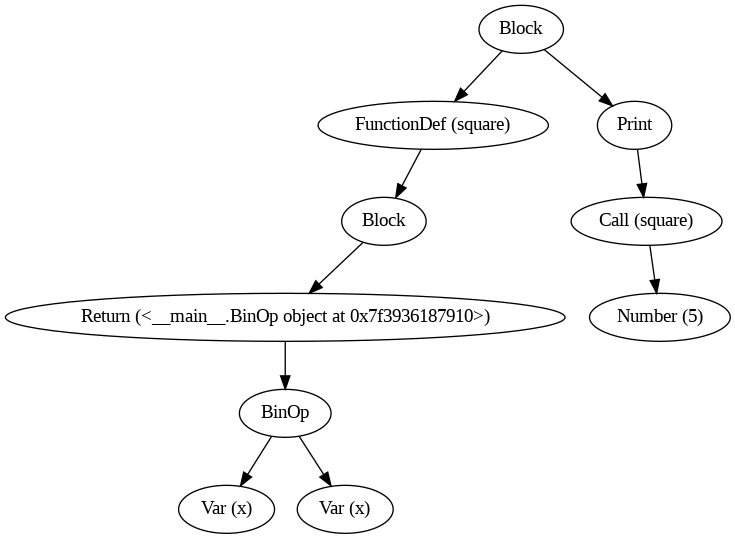

In [36]:
# Parse the code
code = """
def square(x):
    return x * x

print(square(5))
"""
tokens = tokenize(code)
parser = Parser(tokens)
ast = parser.parse()

# Visualize
graph = visualize_ast(ast)
graph.render('ast', format='png', cleanup=True)
from IPython.display import Image
Image('ast.png')


In [37]:
def visualize_bytecode(bytecode):
    graph = Digraph()
    for i, instr in enumerate(bytecode):
        label = f"{i}: {instr[0]}"
        if len(instr) > 1:
            label += " " + " ".join(map(str, instr[1:]))
        graph.node(f"i{i}", label)

        if i < len(bytecode) - 1:
            graph.edge(f"i{i}", f"i{i+1}")

    return graph


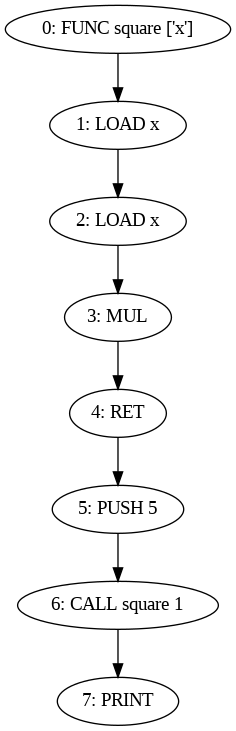

In [38]:
# Visualize compiled bytecode
compiler = Compiler()
bytecode, functions = compiler.compile(ast)
graph = visualize_bytecode(bytecode)
graph.render('bytecode', format='png', cleanup=True)
Image('bytecode.png')
